***A pan-cancer analysis relating microsatellite instability to expression patterns across 33 tumors***

VJ Carey <stvjc@channing.harvard.edu>

This notebook uses information created in the [pancan_tx2 workspace](https://app.terra.bio/#workspaces/landmarkanvil2/pancan_tx2) with resources registered at dockstore.org in the [msireg1 workflow](https://dockstore.org/workflows/github.com/vjcitn/BiocOncoTK/msireg1:master?tab=info).
Specifically, the WDL registered at msireg1 uses Bioconductor's curatedTCGAData and BiocOncoTK packages to collect all RNASeq2GeneNorm measures for 21 genes on each of 9533 tumors from 33 TCGA tumor types, binding MSIsensor scores to all records as continuous measures of microsatellite instability.

**Table of contents**
- [Basic data processing](#basic)
    - [Ingestion and description of workflow output](#ingestion)
    - [Filtering to primary tumors; addition of plate identifiers](#filtering)
    - [Basic visualizations](#viza)
- [Exploring associations between MSI and expression](#basicassoc)
    - [Overview](#assocov)
    - [Two-sample tests](#teststt)
    - [Plate-adjusted linear regression per tumor type](#linreg)

<a id="basic"></a>

## Basic data processing


In [3]:
fn = "gs://bioc_derived_data/msi_ex_33t_21g.rds"

<a id="ingestion"></a>

### Ingestion and description of workflow output


In [4]:
system(paste("gsutil cp ", fn, " ."), intern=TRUE)
newdf = readRDS(basename(fn))

character(0)

In [5]:
library(dplyr, quietly=TRUE)
glimpse(newdf)
length(unique(newdf$patient_barcode))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Observations: 200,193
Variables: 8
$ X               <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ patient_barcode <chr> "TCGA-OR-A5J1", "TCGA-OR-A5J2", "TCGA-OR-A5J3", "TCGA…
$ acronym         <chr> "ACC", "ACC", "ACC", "ACC", "ACC", "ACC", "ACC", "ACC…
$ symbol          <chr> "FOXM1", "FOXM1", "FOXM1", "FOXM1", "FOXM1", "FOXM1",…
$ alias           <chr> "FOXM1", "FOXM1", "FOXM1", "FOXM1", "FOXM1", "FOXM1",…
$ log2ex          <dbl> 6.252206, 9.708816, 7.809840, 10.016878, 4.811296, 11…
$ msival          <dbl> 0.00, 1.57, 1.82, 5.38, 0.00, 0.79, 0.64, 0.90, 0.72,…
$ msicode         <chr> "<4", "<4", "<4", ">=4", "<4", "<4", "<4", "<4", "<4"…


[1] 9533

<a id="filtering"></a>

### Filtering to primary tumors; addition of plate identifiers

In the following chunk, we obtain sample barcodes, from which we can derive
contribution type and plate identifiers, merge these with the workflow output,
and filter the workflow output to primary tumor contributions.

In [6]:
#source("plate_run.R", echo=TRUE)
system("gsutil cp gs://bioc_derived_data/all_plates.rda .", intern=TRUE)
load("all_plates.rda")
allp = do.call(rbind,all_plates)

mx = merge(newdf, allp) # has multiple contributions from some patients
stype=substr(mx$sample_barcode,14,15)
mx$stype = stype
dta = which(table(mx$patient_barcode)==42)
dups = names(dta)
dd = mx[mx$patient_barcode%in%dups,]
# table(dd$patient_barcode, dd$stype) -- shows they all have "01"
nondup = setdiff(mx$patient_barcode, dups)
mx2 = mx %>% filter(patient_barcode %in% nondup|stype == "01")

singplates = filter(mx2, acronym %in% c("ACC", "CHOL", "UCS", "UVM"))
multplates = filter(mx2, !(acronym %in% c("ACC", "CHOL", "UCS", "UVM")))

character(0)

<a id="viza"></a>

### Basic visualizations

#### Surveys of sample numbers and MSIsensor scores per tumor type

In [7]:
library(ggplot2, quietly=TRUE)
options(repr.plot.width=4.8)
one_rec_per_sample = mx2 %>% filter(symbol=="FOXM1")
ntum = ggplot(one_rec_per_sample, aes(factor(acronym))) + geom_bar() + 
   coord_flip() + xlab("TCGA tumor type") + ggtitle("Number of samples per tumor type") 

In [8]:
msidists = ggplot(one_rec_per_sample, aes(y=log10(msival+1), x=factor(acronym))) + 
   geom_boxplot() + coord_flip() + ggtitle("Distributions of MSIsensor scores")

The figure to the right below is very similar to Figure 5B of Bailey 

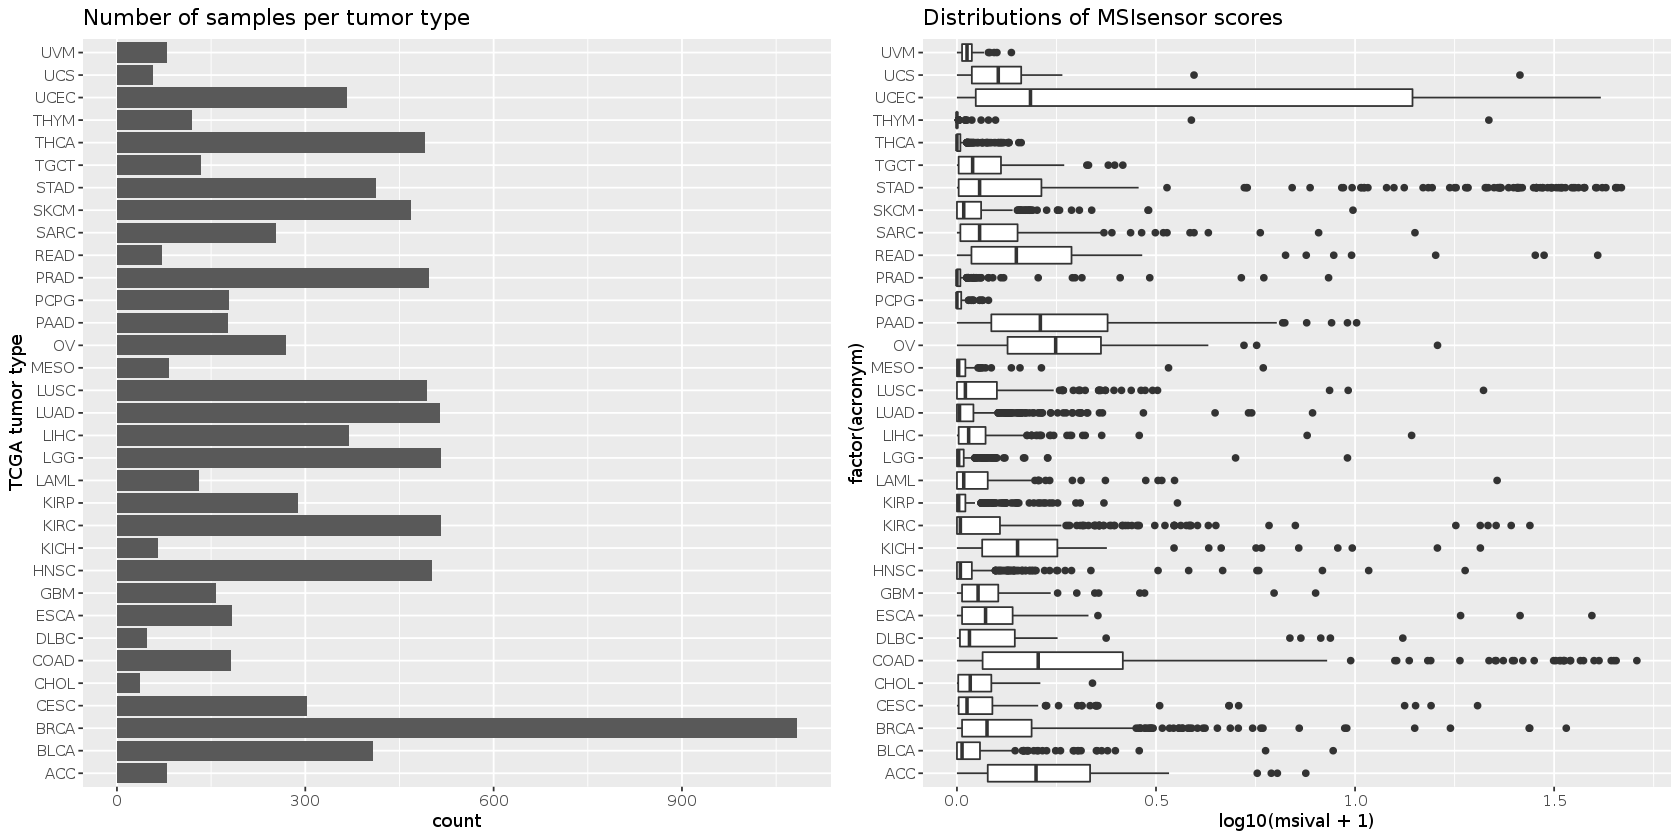

In [11]:
library(ggpubr)
options(repr.plot.width=14,repr.plot.height=7)
ggarrange(ntum,msidists,nrow=1)

#### Bimodality in MSI distributions: two examples

A very weak signal of bimodality of MSIsensor scores is seen in KIRC (Renal Clear Cell Carcinoma); this is more pronounced in stomach cancer.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



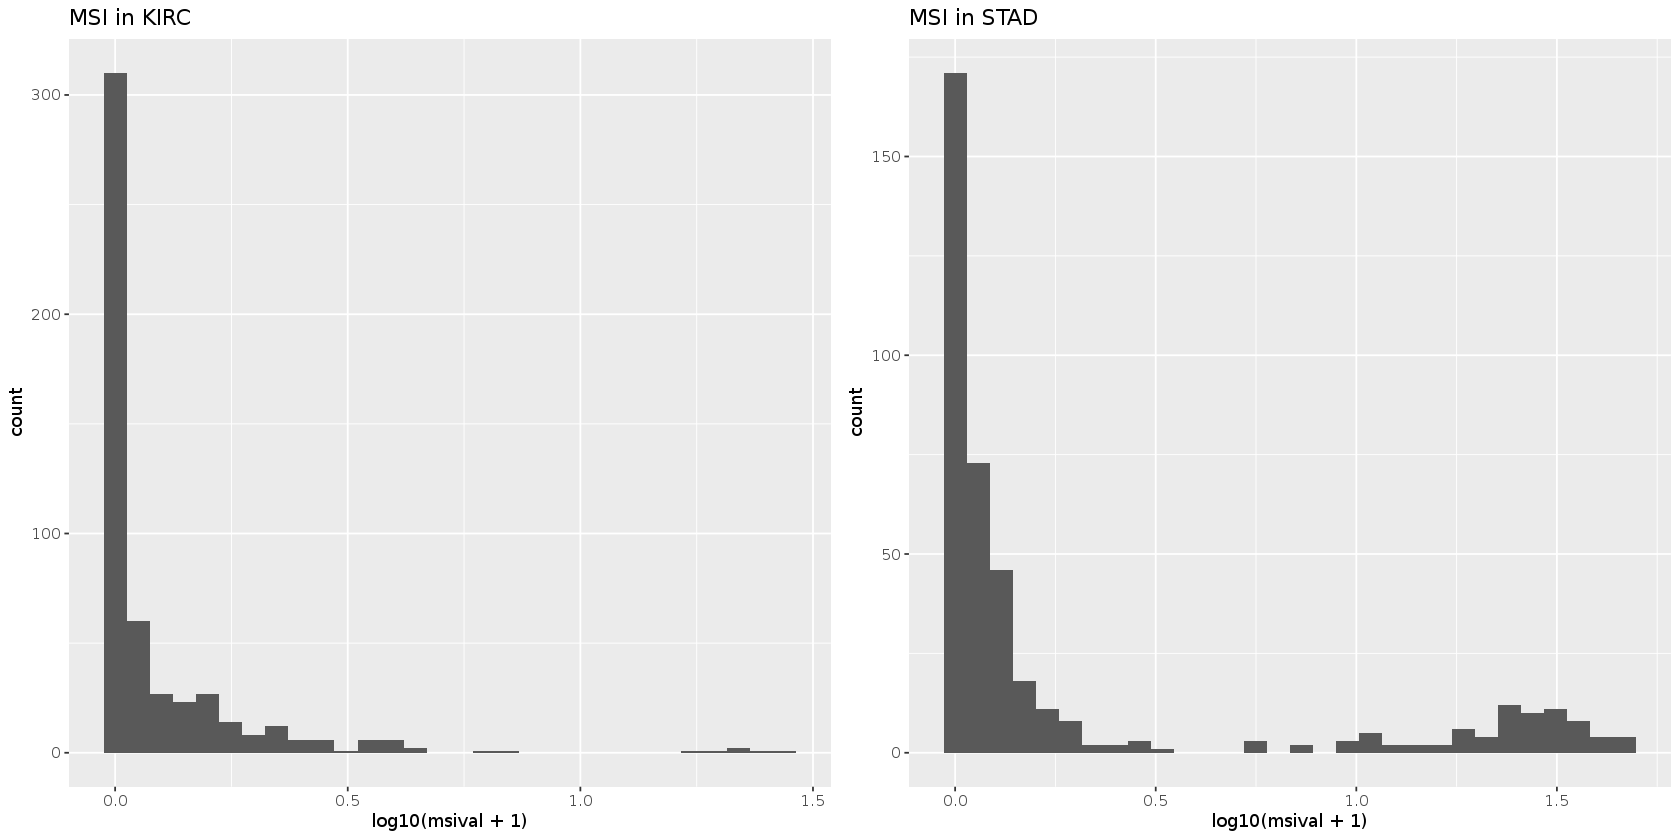

In [13]:
options(repr.plot.width=14)
kirh = ggplot(one_rec_per_sample %>% 
            filter(acronym=="KIRC"), aes(x=log10(msival+1))) + geom_histogram() + ggtitle("MSI in KIRC")
stah = ggplot(one_rec_per_sample %>% 
            filter(acronym=="STAD"), aes(x=log10(msival+1))) + geom_histogram() + ggtitle("MSI in STAD")
ggarrange(kirh,stah,nrow=1)

There is some controversy over the role of MSI in hematologic malignancies (e.g., [Walker et al., 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462842/)).  Numbers are smaller in two examples checked here.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



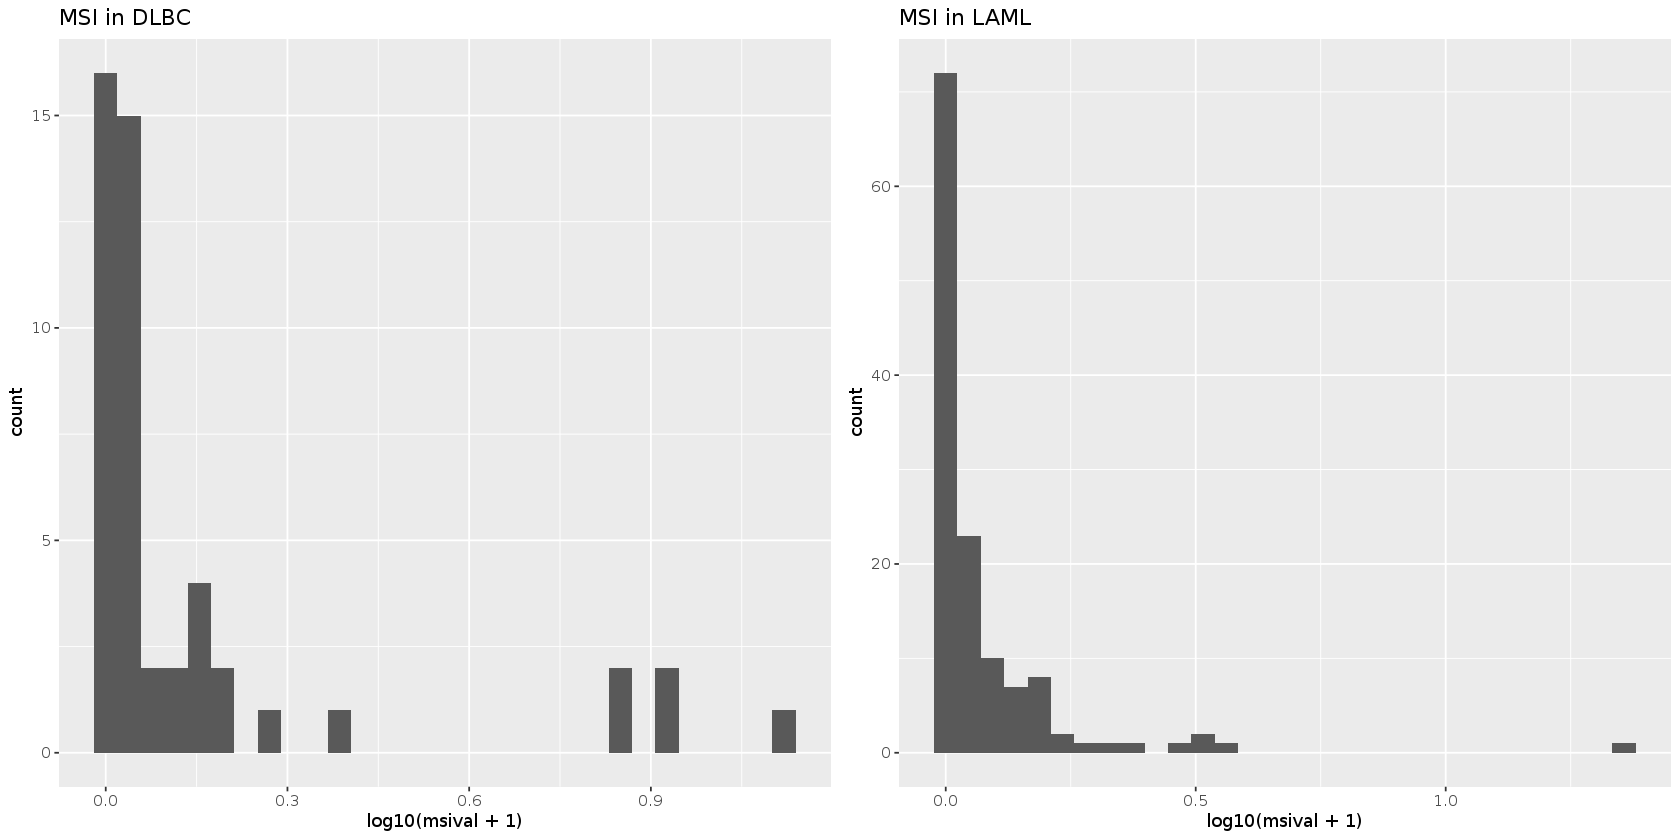

In [15]:
options(repr.plot.width=14)
kirh = ggplot(one_rec_per_sample %>% 
            filter(acronym=="DLBC"), aes(x=log10(msival+1))) + geom_histogram() + ggtitle("MSI in DLBC")
stah = ggplot(one_rec_per_sample %>% 
            filter(acronym=="LAML"), aes(x=log10(msival+1))) + geom_histogram() + ggtitle("MSI in LAML")
ggarrange(kirh,stah,nrow=1)

[Bailey et al. 2018](https://doi.org/10.1016/j.cell.2018.02.060) remark that MSIsensor scores less than 4 do not reliably discriminate MSI from MSS.  We sketch the tumor-specific densities below, marking with a vertical
line the threshold at MSIsensor score 4.

In [16]:
library(scales)
vjctrans = function (p=1)
{
    trans <- function(x) {
        log10(x+p)
     }
    inv <- function(x) {
        (10^(x))-p
    }
    trans_new("vjc", trans, inv)
}


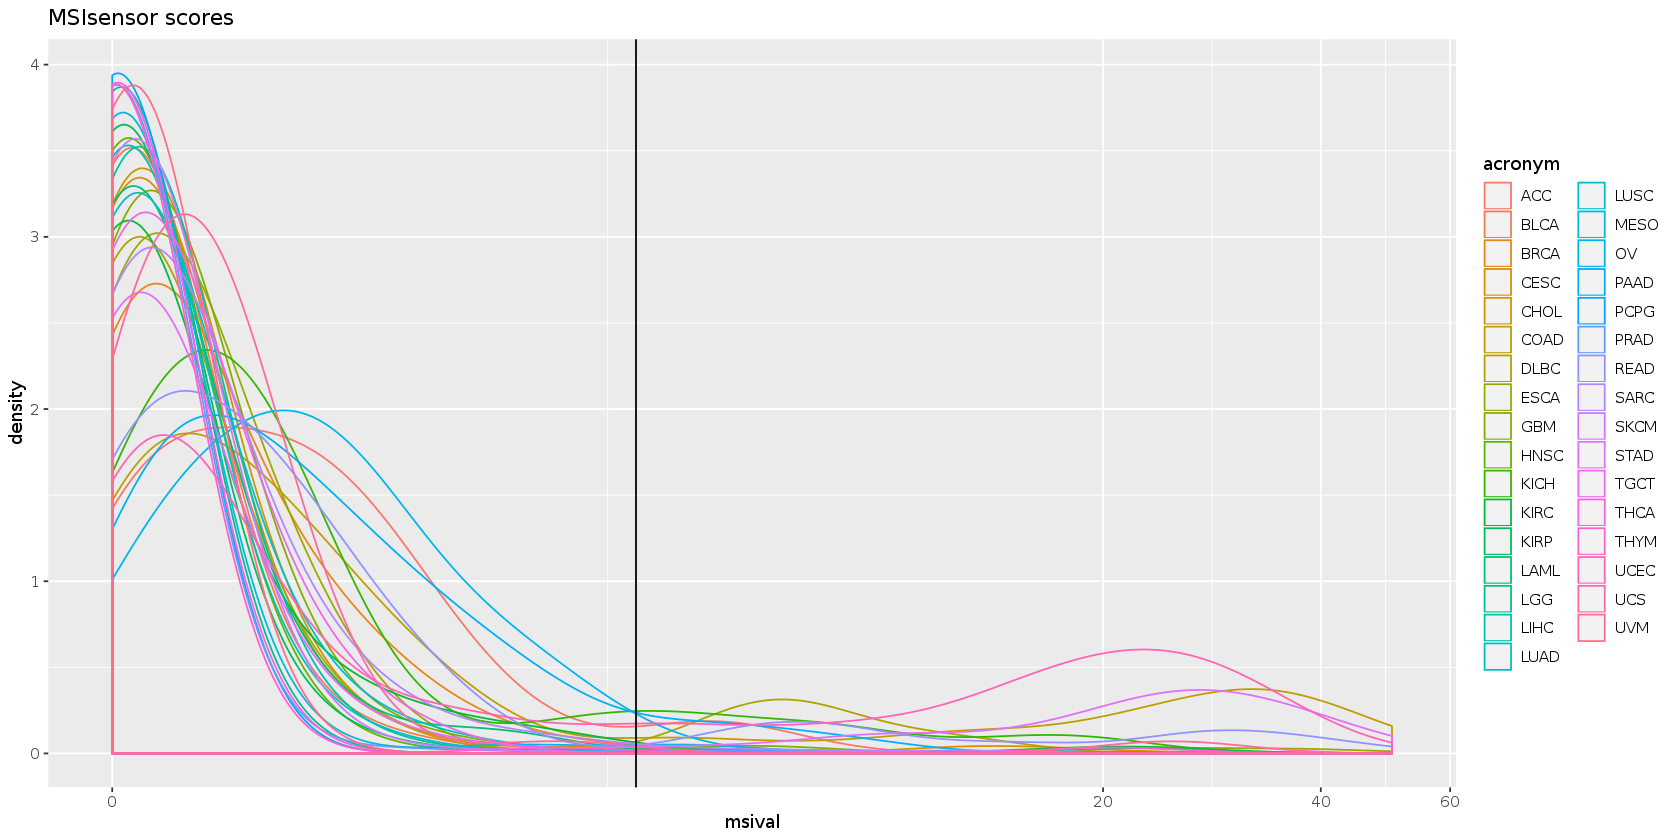

In [17]:
ggplot(one_rec_per_sample, aes(x=msival, colour=acronym)) + 
    geom_density(bw=.1) + ggtitle("MSIsensor scores") + scale_x_continuous(trans=vjctrans()) + geom_vline(xintercept=4)

<a id="basicassoc"></a>

##  Basic associations between MSI and expression

<a id="assocov"></a>

### Overview

We set up the basic code for visualizing stratified and regressive evaluation of association
between MSI and expression of selected genes within TCGA tumor types.

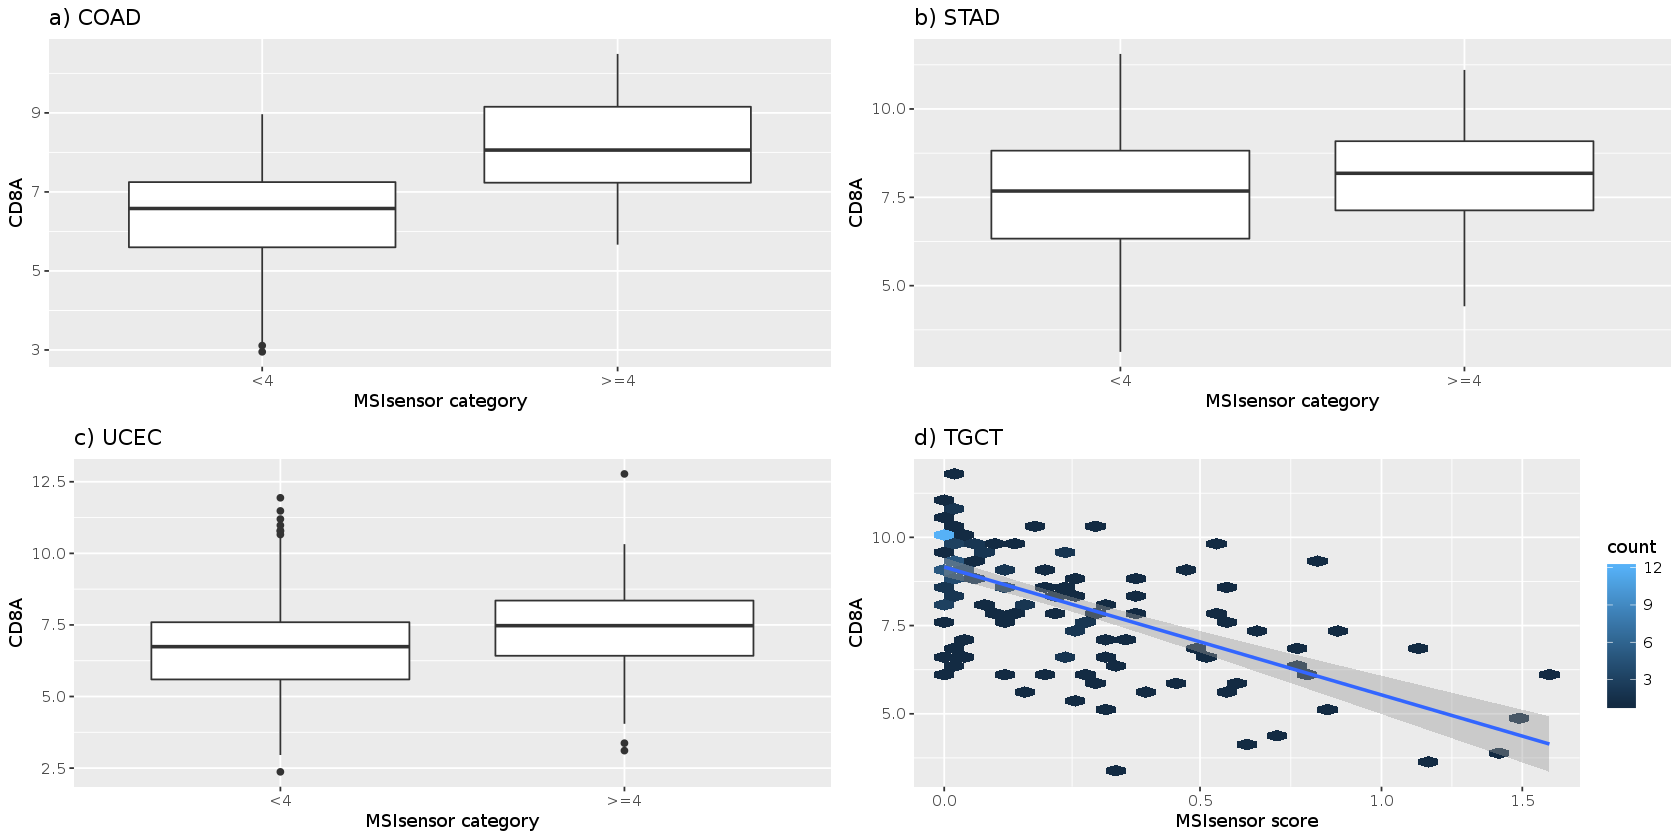

In [18]:
options(repr.plot.width=14,repr.plot.height=7)
ggbox = function(tumor, gene, titlepref="") ggplot(newdf %>% filter(acronym==tumor&symbol==gene), aes(y=log2ex, x=msicode)) + 
 geom_boxplot() + ggtitle(paste0(titlepref,tumor)) + ylab(gene) + xlab("MSIsensor category")
ggscat = function(tumor, gene, titlepref="", intrans=vjctrans(p=1),inmeth="auto", topmsi=Inf) ggplot(newdf %>% filter(acronym==tumor&symbol==gene&msival<topmsi), aes(y=log2ex, x=msival)) + 
 geom_hex() + ggtitle(paste0(titlepref,tumor)) + ylab(gene) + scale_x_continuous(trans=intrans) + geom_smooth(method=inmeth) +
 xlab("MSIsensor score")
co = ggbox("COAD", "CD8A", titlepref="a) ")
st = ggbox("STAD", "CD8A", titlepref="b) ")
uc = ggbox("UCEC", "CD8A", titlepref="c) ")
tg = ggscat("TGCT", "CD8A", titlepref="d) ",inmeth=MASS::rlm)
ggarrange(co,st,uc,tg,nrow=2,ncol=2)

We define a function that gives a pair of plots for a given tumor-gene combination, allowing for different
transformations, regression displays (parameter inmeth drives the geom_smooth method), and xlims (topmsi parameter
defines the upper bound for xlim interval).

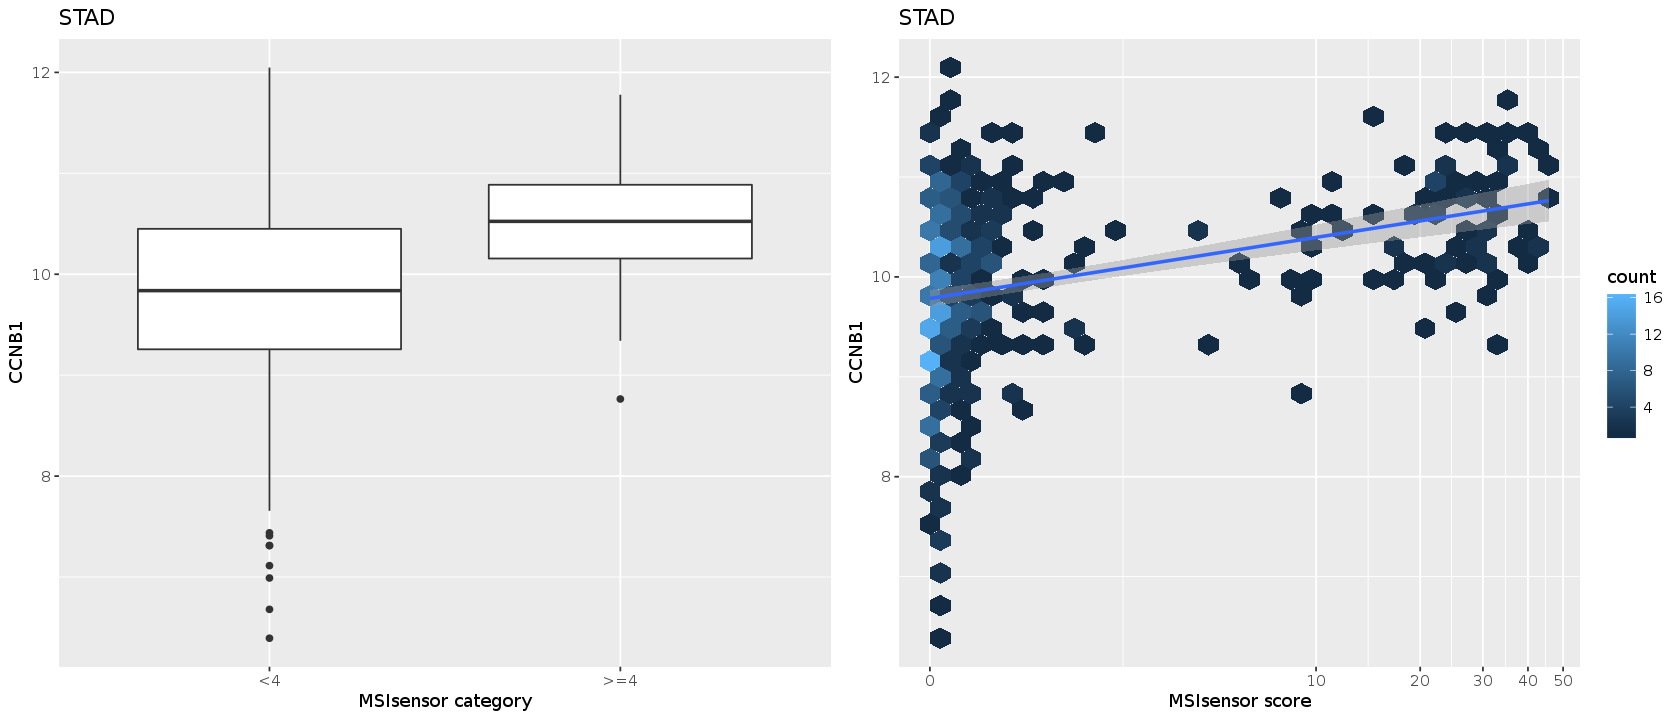

In [21]:
demo = function(tum="COAD", gene="TYMS", intrans=vjctrans(p=1), inmeth="auto", topmsi=Inf) {
    g1 = ggbox(tum,gene)
    g2 = ggscat(tum,gene, intrans=intrans, inmeth=inmeth, topmsi=topmsi)#+geom_vline(xintercept=4)
    #ggarrange(g1,g2,nrow=1)
    list(g1,g2)
}
d1 = demo("STAD", "CCNB1",inmeth=MASS::rlm)
options(repr.plot.width=14,repr.plot.height=6)
ggarrange(d1[[1]],d1[[2]],nrow=1)

<a id="teststt"></a>

### Two-sample tests

We now prepare to carry out t tests for association between expression and MSIsensor value, thresholded at 4.  The data are coded so that a negative t statistic implies 
_greater_ mean expression for tumors with MSIsensor score above 4.

In [22]:
tum = unique(newdf$acronym)
gn = unique(newdf$alias)
tg = expand.grid(tumor=tum, gene=gn)
i=1
with(newdf %>% filter(acronym==tg$tumor[i]&symbol==tg$gene[i]), t.test(log2ex~msicode))
class(newdf$msicode)


	Welch Two Sample t-test

data:  log2ex by msicode
t = -1.7067, df = 3.7588, p-value = 0.1677
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.6497160  0.6640509
sample estimates:
 mean in group <4 mean in group >=4 
         8.506112          9.498945 


[1] "character"

In this chunk we collect t statistics for all gene-tumor pairs.  For tumors with no MSIsensor score greater than 4, NAs are returned.

In [23]:
t1 = function(i) with(newdf %>% filter(acronym==tg$tumor[i]&symbol==tg$gene[i]), {
    tt = t.test(log2ex~msicode)
    tstat = tt$statistic
    p.val = tt$p.value
    c(tstat=tstat, pval=p.val)
    })
allp = sapply(1:nrow(tg), function(x) {
    ans = try(t1(x),silent=TRUE); 
    if (inherits(ans, "try-error")) return(c(tstat=NA,pval=NA))
    ans})

We transform the collection of p-values to Benjamini-Hochberg FDR.

In [24]:
t.tests = cbind(tg,raw.p.t=allp["pval",],tstat=allp["tstat.t",])
library(multtest)
adjp = mt.rawp2adjp(allp["pval",], proc="BH")

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
   

In [25]:
np = adjp$adjp[order(adjp$index),]
np = cbind(t.tests,np)
sig.t = np[which(np[,"BH"]<0.05),]
sig.t$tumor = as.character(sig.t$tumor)
sig.t$gene = as.character(sig.t$gene)
dim(sig.t)
head(sig.t %>% arrange(BH))

[1] 40  6

tumor,gene,raw.p.t,tstat,rawp,BH
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
STAD,TYMS,4.509690e-27,-12.739755,4.509690e-27,3.125215e-24
COAD,TYMS,1.195560e-23,-13.512375,1.195560e-23,4.142616e-21
BLCA,CEP55,1.878986e-22,-10.355477,1.878986e-22,4.340457e-20
STAD,CCNB1,2.616038e-17,-9.337220,2.616038e-17,4.532286e-15
STAD,CEP55,7.402448e-14,-8.149123,7.402448e-14,1.025979e-11
BLCA,SATB1,3.007088e-13,34.017743,3.007088e-13,3.473186e-11


We'll present the results as a bipartite graph.  We'll use orange for genes regarded as prognostically unfavorable by [Gentles et al. 2015](http://dx.doi.org/10.1038/nm.3909), and blue for the collection of favorable genes along with CD8A.  Edges linking tumors with genes for which MSIsensor score is significantly positively associated (t-test based FDR < 0.05) with expression are colored blue; edges corresponding to negative associations are colored orange.

In [26]:
library(graph)
g = new("graphNEL", edgemode="directed",
        nodes = unique(c(sig.t$tumor,sig.t$gene)))
for (i in 1:nrow(sig.t)) g = addEdge(to=sig.t$gene[i], from=sig.t$tumor[i], g)

In [27]:
graph::graph.par(list(nodes=list(shape="rectangle", cex=.65, lwd=0)))
library(Rgraphviz)
g

Loading required package: grid



A graphNEL graph with directed edges
Number of Nodes = 29 
Number of Edges = 40 

In [28]:
adv = c("FOXM1", "BIRC5", "TOP2A", "TPX2", "NME1", "CCNB1", "CEP55", 
"TYMS", "CENPF", "CDKN3")

fav = c("KLRB1", "ITM2B", "CBX7", "CD2", "CREBL2", 
"SATB1", "NR3C1", "TMEM66", "KLRK1", "FUCA1", "CD8A")

Decorating the graph for rendering with Rgraphviz takes a bit of work.  We use nodeRenderInfo to color gene names with respect to the Gentles classification, leaving tumor names uncolored.  Use of edgeRenderInfo requires
construction of edge-element names with the form `[tumor]~[gene]`.

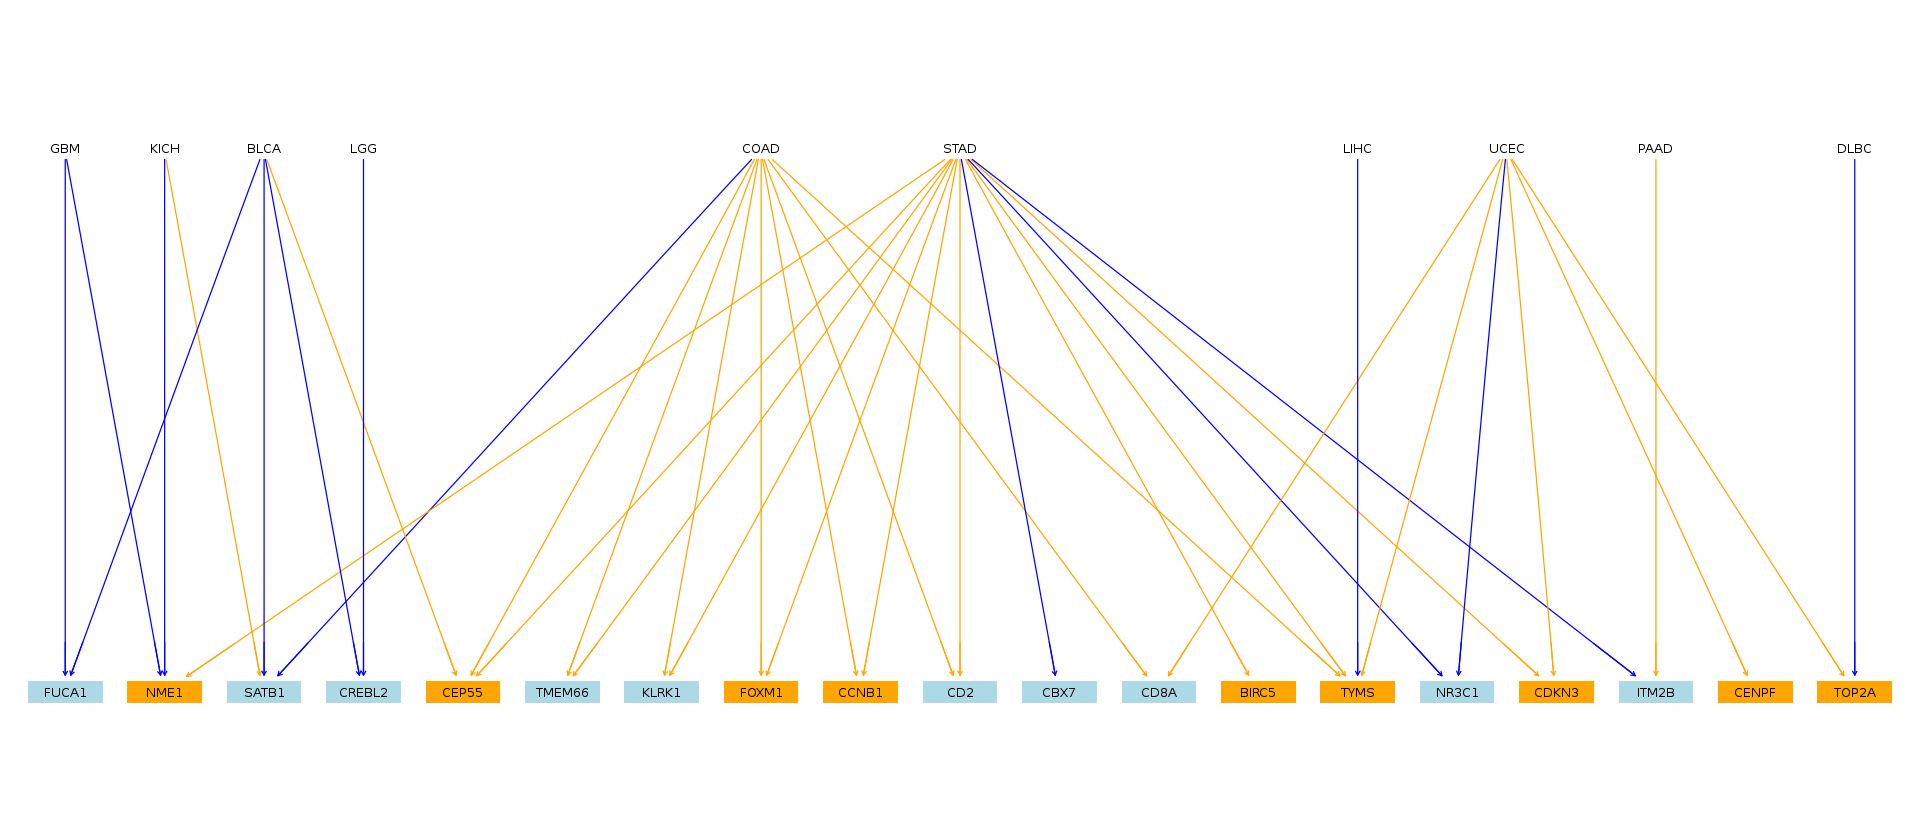

In [31]:
#plot(g)
gnel = Rgraphviz::layoutGraph(g)
nodeRenderInfo(gnel)$fill[] = ifelse(nodes(g) %in% fav, "lightblue", 
                                     ifelse(nodes(g) %in% gn, "orange", "transparent"))
enm = paste0(sig.t$tumor,"~",sig.t$gene)
tst = sig.t$tstat
edgeRenderInfo(gnel)$col[enm][] = ifelse(tst<0,"orange", "blue") # see note about directionality above
options(repr.plot.width=16,repr.plot.height=7)
Rgraphviz::renderGraph(gnel)

To demonstrate how to read the graph, we examine four tumors and the qualitatively different relationships
observed between MSI and gene expression.  For GBM and KICH, higher MSI is associated with decreased NME1 expression, as indicated by the edges color blue.  For STAD and and COAD, higher MSI is associated with increased FOXM1 expression, and the associated edges are orange.

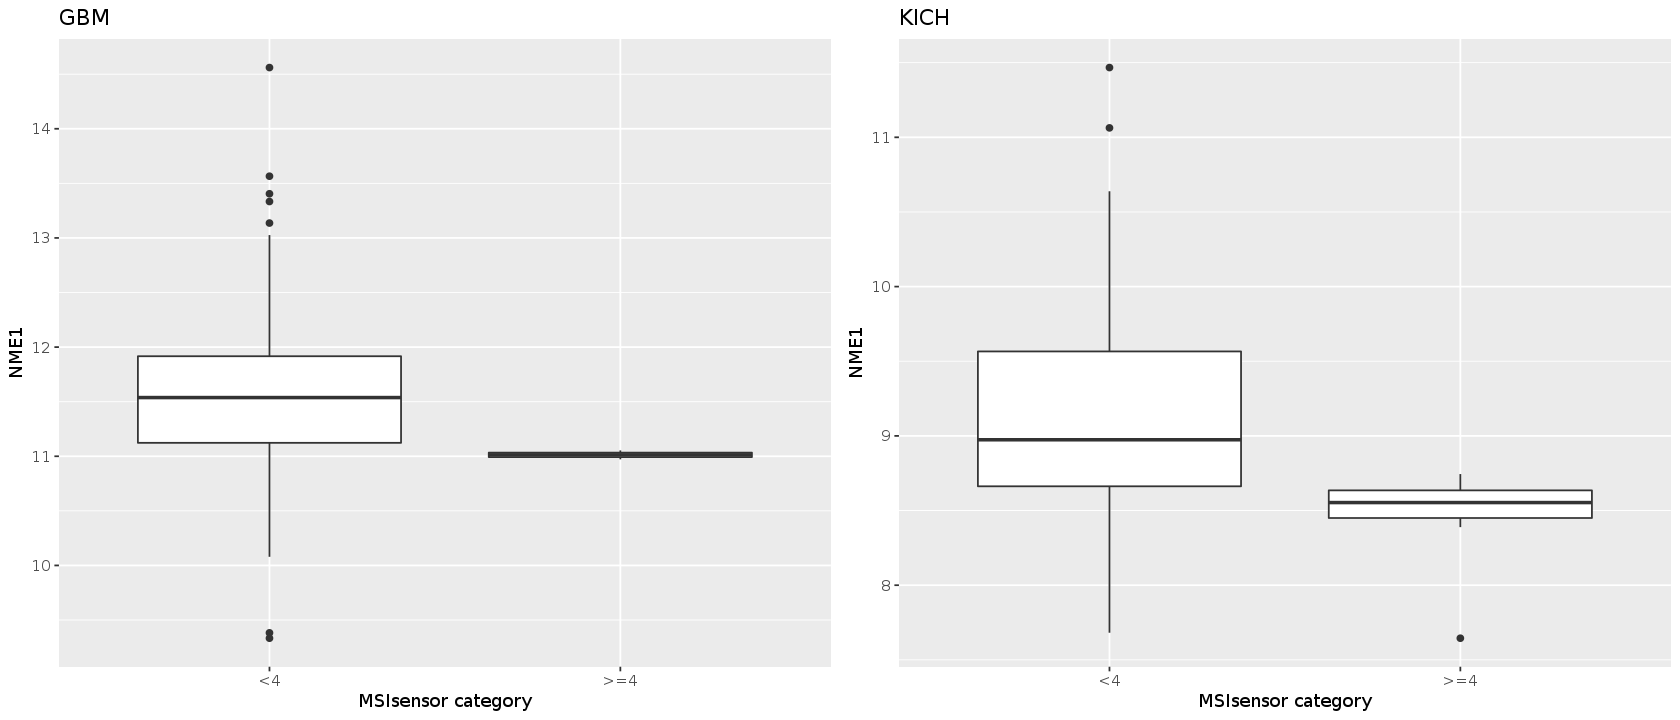

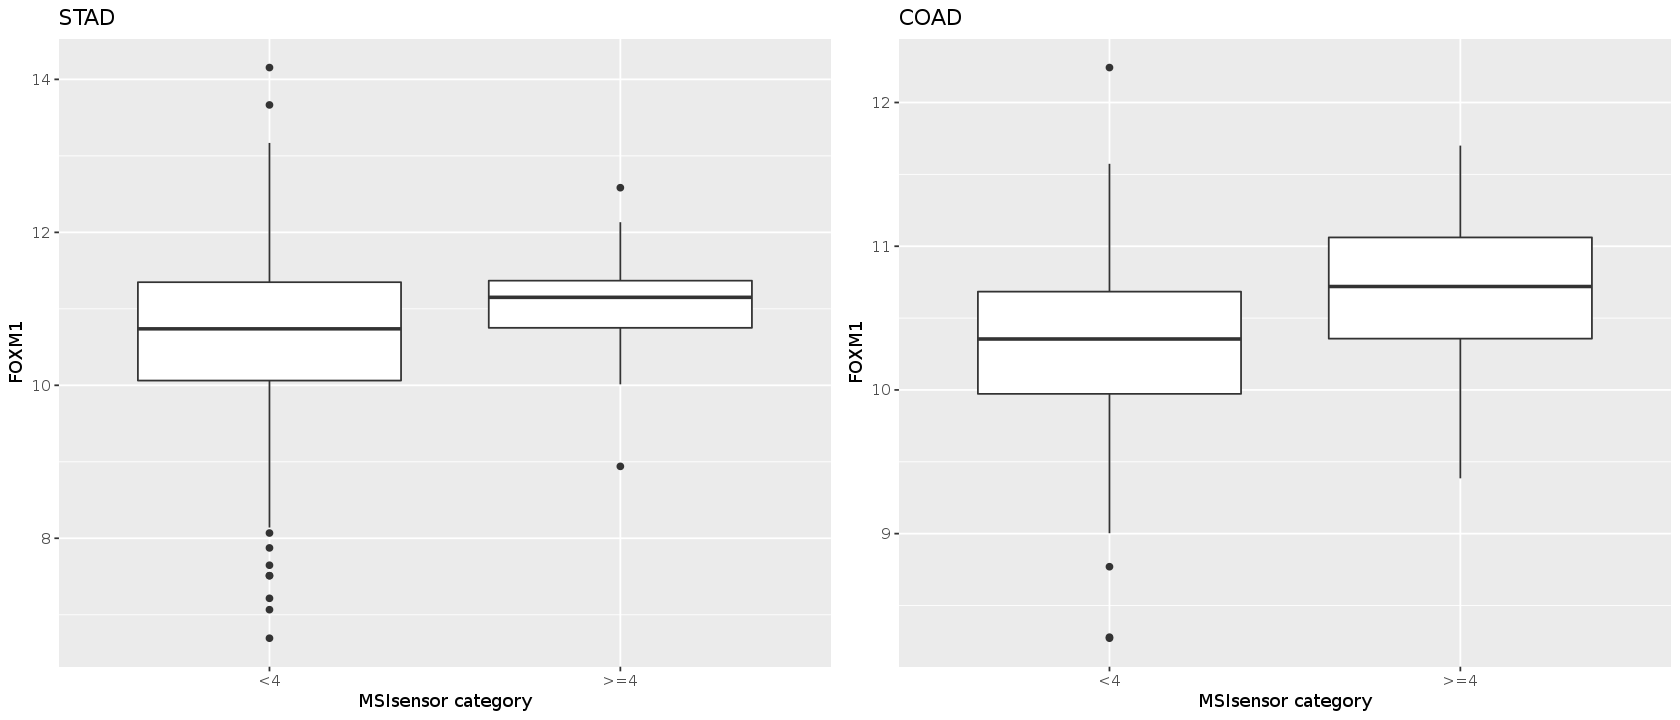

In [33]:
d1 = demo("GBM", "NME1",inmeth=MASS::rlm)
d2 = demo("KICH", "NME1", inmeth=MASS::rlm)
d3 = demo("STAD", "FOXM1",inmeth=MASS::rlm)
d4 = demo("COAD", "FOXM1", inmeth=MASS::rlm)
options(repr.plot.width=14,repr.plot.height=6)
ggarrange(d1[[1]],d2[[1]],nrow=1)
ggarrange(d3[[1]],d4[[1]],nrow=1)

<a id="linreg"></a>

### Plate-adjusted linear regression per tumor type

In [34]:
library(tidyr)
library(broom)
mods_sing = singplates %>% group_by(acronym,alias) %>% 
  do(model=lm(log2ex~log(msival+1), data=.)) 
tmods_sing = tidy(mods_sing, model)
stats_sing = tmods_sing %>% filter(term=="log(msival + 1)") 
r2_sing = sapply(mods_sing$model, function(x)summary(x)$adj.r.squared)
stats_sing$r2 = r2_sing

mods_mult = multplates %>% group_by(acronym,alias) %>% 
  do(model=lm(log2ex~log(msival+1)+factor(plate), data=.)) 
tmods_mult = tidy(mods_mult, model)
stats_mult = tmods_mult %>% filter(term=="log(msival + 1)") 
r2_mult = sapply(mods_mult$model, function(x)summary(x)$adj.r.squared)
stats_mult$r2 = r2_mult
                 


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract




In [35]:
mods_unadj = mx2 %>% group_by(acronym,alias) %>% 
  do(model=lm(log2ex~log(msival+1), data=.)) 
tmods_un = tidy(mods_unadj, model)
stats_un = tmods_un %>% filter(term=="log(msival + 1)") 
r2_un = sapply(mods_unadj$model, function(x)summary(x)$adj.r.squared)
stats_un$r2 = r2_un

In [36]:
allstats = rbind(stats_sing,stats_mult)

In [37]:
head(allstats)

acronym,alias,term,estimate,std.error,statistic,p.value,r2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACC,BIRC5,log(msival + 1),0.6328691,0.5230877,1.209872,0.230029396,0.005910875
ACC,CBX7,log(msival + 1),0.3568761,0.2661522,1.340873,0.183904123,0.010126396
ACC,CCNB1,log(msival + 1),0.9165439,0.2882344,3.179856,0.002123432,0.104595652
ACC,CD2,log(msival + 1),-1.2604521,0.5843383,-2.157059,0.034120728,0.044736972
ACC,CD8A,log(msival + 1),-0.8875834,0.5195090,-1.708505,0.091571160,0.024011661
ACC,CDKN3,log(msival + 1),1.1142456,0.4153297,2.682798,0.008931776,0.073605659


In [38]:
library(multtest)
mt = mt.rawp2adjp(allstats$p.value, proc="BH")
myd = mt$adjp[order(mt$index),]
colnames(myd) = c("rawp", "BH")
allst = data.frame(allstats, myd)
head(allst)

acronym,alias,term,estimate,std.error,statistic,p.value,r2,rawp,BH
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACC,BIRC5,log(msival + 1),0.6328691,0.5230877,1.209872,0.230029396,0.005910875,0.230029396,0.364783458
ACC,CBX7,log(msival + 1),0.3568761,0.2661522,1.340873,0.183904123,0.010126396,0.183904123,0.308701018
ACC,CCNB1,log(msival + 1),0.9165439,0.2882344,3.179856,0.002123432,0.104595652,0.002123432,0.008361015
ACC,CD2,log(msival + 1),-1.2604521,0.5843383,-2.157059,0.034120728,0.044736972,0.034120728,0.081487305
ACC,CD8A,log(msival + 1),-0.8875834,0.5195090,-1.708505,0.091571160,0.024011661,0.091571160,0.181310898
ACC,CDKN3,log(msival + 1),1.1142456,0.4153297,2.682798,0.008931776,0.073605659,0.008931776,0.027881625


In [39]:
sigslopes = allst %>% filter(BH<0.05)
dim(sigslopes)
head(sigslopes)

[1] 246  10

acronym,alias,term,estimate,std.error,statistic,p.value,r2,rawp,BH
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACC,CCNB1,log(msival + 1),0.9165439,0.2882344,3.179856,0.002123432,0.10459565,0.002123432,0.008361015
ACC,CDKN3,log(msival + 1),1.1142456,0.4153297,2.682798,0.008931776,0.07360566,0.008931776,0.027881625
ACC,CENPF,log(msival + 1),1.0900898,0.3962956,2.750699,0.007409409,0.07764725,0.007409409,0.024805413
ACC,FOXM1,log(msival + 1),1.2816593,0.3790634,3.381121,0.001136526,0.11796616,0.001136526,0.005081372
ACC,TOP2A,log(msival + 1),1.3027565,0.4124857,3.158307,0.002267152,0.10318958,0.002267152,0.008728534
ACC,TPX2,log(msival + 1),0.9297469,0.3316233,2.803624,0.006391656,0.08084233,0.006391656,0.021819792


In [40]:
slg = new("graphNEL", edgemode="directed",
        nodes = unique(c(sigslopes$acronym,sigslopes$alias)))
for (i in 1:nrow(sigslopes)) slg = addEdge(to=sigslopes$alias[i], from=sigslopes$acronym[i], slg)
slg

A graphNEL graph with directed edges
Number of Nodes = 49 
Number of Edges = 246 

For the regression tests, a positive slope relating MSIsensor score to 

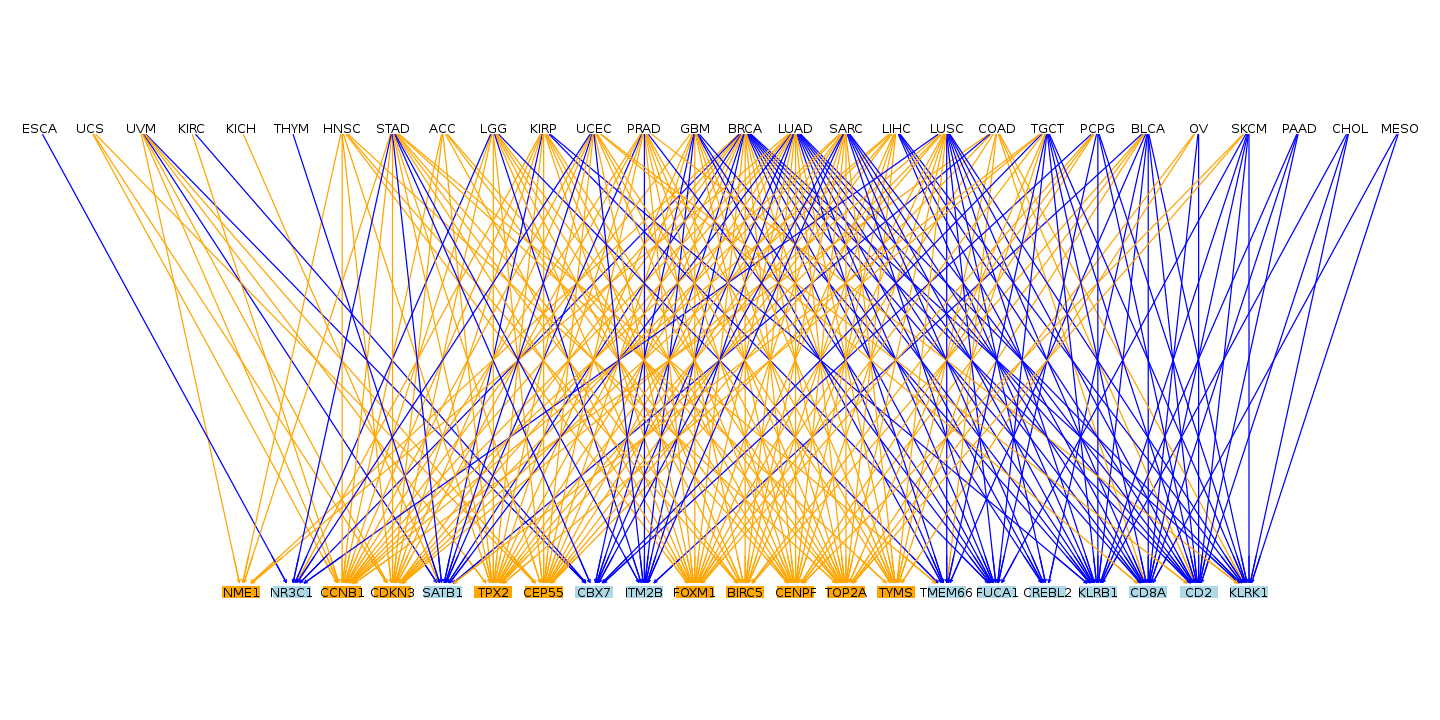

In [45]:
gnel = Rgraphviz::layoutGraph(slg)
nodeRenderInfo(gnel)$fill[] = ifelse(nodes(slg) %in% fav, "lightblue", 
                                     ifelse(nodes(slg) %in% gn, "orange", "transparent"))
enm = paste0(sigslopes$acronym,"~",sigslopes$alias)
tst = sigslopes$statistic
edgeRenderInfo(gnel)$col[enm][] = ifelse(tst>0,"orange", "blue") # see note about directionality above
options(repr.plot.width=12,repr.plot.height=6)
Rgraphviz::renderGraph(gnel)

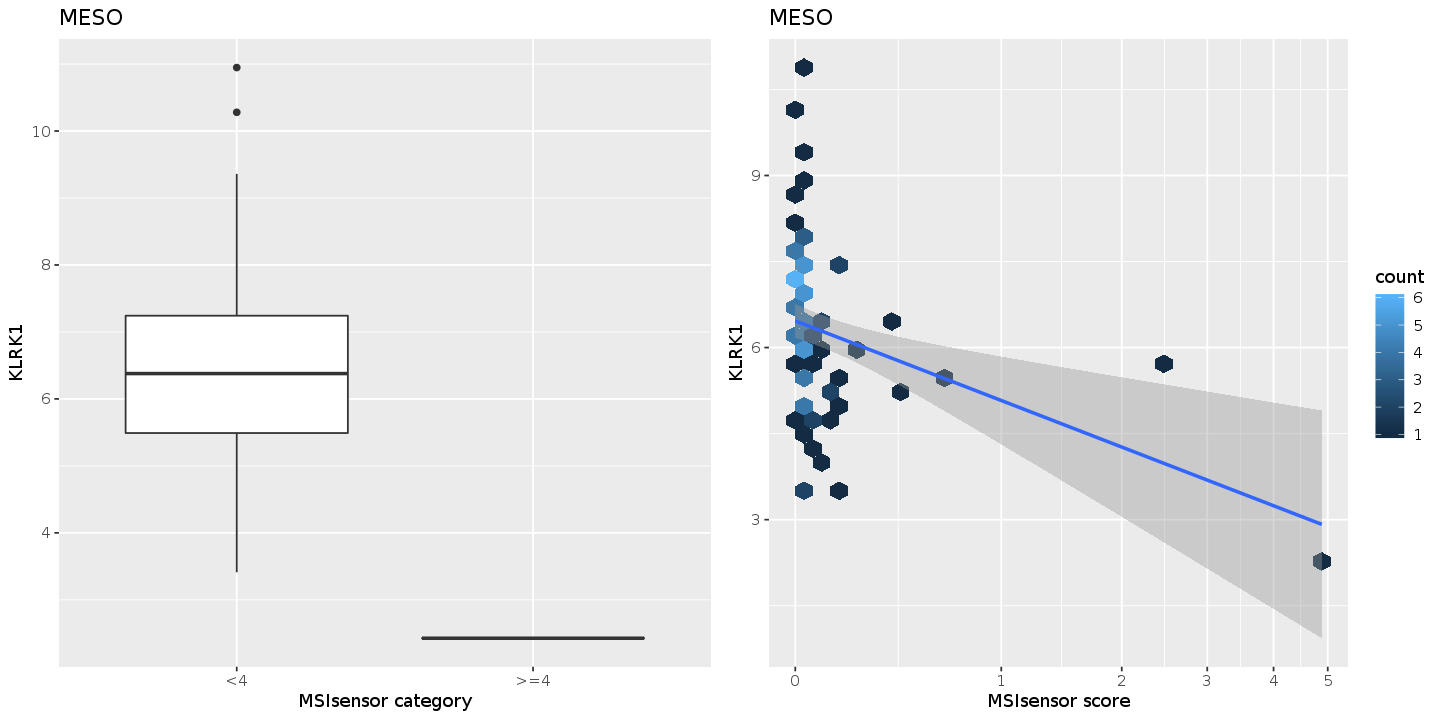

In [46]:
dd = demo("MESO", "KLRK1", inmeth=MASS::rlm)
ggarrange(dd[[1]],dd[[2]],nrow=1)